In [1]:
# Add some formatting to the document.
from IPython.core.display import HTML

HTML("""
<style>
* { 
    line-height: 150%;
}
</style>
""")

# Träning av CNN
### Modell för att klassifisera tecken

Det som finns i denna Jupyter Notebook är den kod som använts för att träna den CNN modell som använts för detta projekt. Det är en modell som bygger på överförd inlärning från modellen Xception och som har tränats på EMNIST, en förlängd version av MNIST som även innehåller bokstäver. Syftet med modellen är då att kunna klassifiera bokstäverna A-Z samt siffrorna 0-9. Små bokstäver ignoreras då projektet går ut på att lösa av ritade "knappar", som i regel ska bara har stora bokstäver. Sedan togs inte specialtecken med (så som frågetecken och citat) då data saknades för denna träning och modellen tog redan som det var lång tid att träna.

*Notera att modellen har tränats på lokal dator p.g.a. begränas tillgång till Google Colab.*

**Xception:** https://www.kaggle.com/datasets/crawford/emnist
**EMNIST:** https://www.kaggle.com/datasets/crawford/emnist

Denna fil innehåller en kod från de tidigare labbarna som utförts inom kursen, men med modifieringar för att passa just detta fall.

## Setup
Första steget blir att förbereda vårt program genom att importera det vi behöver och justera inställningar för att nyttja CUDA-kärnor, float16, installera saknade bibliotek och så vidare...

In [2]:
# AI libraries.
import  tensorflow as tf
import  keras

from    keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D
from    keras.utils import to_categorical
from    keras.callbacks import EarlyStopping

# Helper libraries.
import  numpy as np
from    sklearn.model_selection import train_test_split

# Libraries for plotting.
import  matplotlib.pyplot as plt

# Other.
import gc
import csv
import subprocess
import zipfile
import os

2024-01-11 11:41:40.315241: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 11:41:40.315349: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 11:41:40.439410: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 11:41:40.649613: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 11:41:41.834972: W tensorflow/compiler/tf2

In [3]:
# Code taken from Lab #1.
# Test for GPU and determine what GPU we have.
import sys
import os
if not tf.config.list_physical_devices('GPU'):
	print("No GPU was detected. CNNs can be very slow without a GPU.")
	IN_COLAB = 'google.colab' in sys.modules
	if IN_COLAB:
		print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
	# Ignore this error as Google Colab doesn't have support for os-commands.
	!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2070 SUPER (UUID: GPU-2b4bf949-1bc2-f67e-7e07-7a49155e41a6)


2024-01-11 11:41:44.396477: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 11:41:44.863233: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 11:41:44.863506: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
# Code taken form course Canvas page.
# Used for enabling float16 to speed up computations and save memory.

gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    compute_capability=details.get('compute_capability')
    print("Compute capability:",compute_capability)
    if compute_capability[0]>6:
        print("Turn on mixed_float16")
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)

2024-01-11 11:41:45.071129: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Compute capability: (7, 5)
Turn on mixed_float16
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5


2024-01-11 11:41:45.224382: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [5]:
# Modify GPU memory allocator to try to prevent full GPU memory.
# Warning: This can in some cases be counter productive!
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [6]:
# Set random seed for consists results.
seed = 42
keras.utils.set_random_seed(seed)

In [7]:
# Model settings.
image_size = (112, 112, 1)  # Image input size. Note that we must work with three colors as Xception requires this.
chars_up_to = 36            # Import up to character 36 as the ones after this are lower case.

In [8]:
# Install Keras Tuner via PIP (if in colab).
import sys
if 'google.colab' in sys.modules:
    # Ignore the error below. It's due to missing missing support for os-commands in Google Colab.
    !pip install keras_tuner

import keras_tuner
print('Keras Tuner version:', keras_tuner.__version__)

Keras Tuner version: 1.4.6


## Behandling av data

Nu när filen är redo är det dags att börja bearbeta vår data.

Det dataset som kommer användas för att tränna denna modell är EMNIST, som är en utökad version an den klassiska MNIST. EMNIST har utöver siffror, även bokstäder (ej "å", "ä" eller "ö"). Datasettet kommer i olika formateringar, men det av intresse kallas för "balanced" då den är balanceras så att modellen kan tränar lika mycket för alla olika tecken. Detta viktigt då modellen behöver vara väl balanserad och kan inte bli det om vi tränar det mer för t.ex. siffran "5" än bokstaden "h". På Keggle skriver man *"..to reduce mis-classification errors due to capital and lower case letters and also has an equal number of samples per class. This dataset is meant to be the most applicable."*.

Länk till datasettet: https://www.kaggle.com/datasets/crawford/emnist

En förminskade version av datasettet finns lagrad på en av studentens FTP-serverar: https://qoncer.com/downloads/emnist_balanced.zip

In [9]:
# Function to download the dataset.
def get_dataset(zip_url, file_name):

    # Directory to save the downloaded file and extract the contents.
    download_dir = "datasets"
    zip_file_path = os.path.join(download_dir, file_name)

    # Stop if the file already exists.
    if os.path.exists(zip_file_path):
        print("Dataset already exists.")
        return

    # Create the "datasets" directory if it doesn't exist.
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)

    # Download the zip file using curl.
    curl_command = ["curl", "-o", zip_file_path, zip_url]
    subprocess.run(curl_command)

    # Unzip the downloaded file.
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(download_dir)

    print("Download and extraction complete.")

# Call the function to get the dataset.
get_dataset("https://qoncer.com/downloads/emnist_balanced.zip", "emnist_balanced.zip")


Dataset already exists.


För att kunna klassifisera bilderna behöver vi ladda in alla klassernas ASCII koder baserade på index-värden. Detta gör vi med funktionen nedan. Notera hur den kapar datan föra tt inte inkludera index-värden (då ASCII-koderna placeras på dessa index i en ny array) eller de små bokstäverna (argument **characters_up_yo**). För mer information om ASCII, besök: https://www.ascii-code.com/

In [59]:
# Function the read and filter the ascii codes.
def read_ascii_codes(ascii_codes_file, characters_up_to):

    try:
        with open(ascii_codes_file, 'r') as file:
            # Read the entire content of the file and store.
            ascii_codes = file.read()
    except FileNotFoundError:
        print(f"The file {ascii_codes_file} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

    # Convert into a numpy array.
    ascii_codes = np.array(ascii_codes.splitlines())

    # Filter.
    ascii_codes = ascii_codes[:characters_up_to]

    # Remove the indices and turn into integers.
    for i in range(len(ascii_codes)):
        ascii_codes[i] = ascii_codes[i].split()[1]

    # Return results.
    return ascii_codes



# Get codes and explore the result.
ascii_codes = read_ascii_codes("datasets/emnist_balanced/emnist-balanced-mapping.txt", chars_up_to)
print(ascii_codes)
print(f"Length: {len(ascii_codes)}")
for i in range(len(ascii_codes)):
    print(chr(int(ascii_codes[i])))

['48' '49' '50' '51' '52' '53' '54' '55' '56' '57' '65' '66' '67' '68'
 '69' '70' '71' '72' '73' '74' '75' '76' '77' '78' '79' '80' '81' '82'
 '83' '84' '85' '86' '87' '88' '89' '90']
Length: 36
0
1
2
3
4
5
6
7
8
9
A
B
C
D
E
F
G
H
I
J
K
L
M
N
O
P
Q
R
S
T
U
V
W
X
Y
Z


Ovan ser vi i det utskrivna resultatet att vi har totalt 36 olika tecken. Vi ser även alla ASCII-koder utskrivna.

Nästa steg är att ladda in träningsdata och testdata.

In [11]:
# Function that reads from CSV files and returns their contents.
def read_csv(file_path, include_up_to_index):
    res = None
    try:
        with open(file_path, 'r') as file:
            # Create a CSV reader object.
            csv_reader = csv.reader(file)
            # Filter array certain incides.
            res = np.array([row for row in csv_reader if int(row[0]) < include_up_to_index])
    except FileNotFoundError:
        print(f"The file {file_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")
    return res



# Files to read from.
train_file = "datasets/emnist_balanced/emnist-balanced-train.csv"
test_file = "datasets/emnist_balanced/emnist-balanced-test.csv"



# Call the function and store the results.
train_data = read_csv(train_file, len(ascii_codes))
test_data = read_csv(test_file, len(ascii_codes))

In [12]:
# Explore the data shapes.
print(train_data.shape)
print(test_data.shape)

(86400, 785)
(14400, 785)


Nu när vi har laddat in vår data ska vi utforska formen på den för att se vad vi har att arbete med. Vi ser att i första filen har vi $86400$ rader, och i andra $14400$ rader. Där varje rad är en bild. Notera hur andra värden i "shape" är $785$. Detta beror på att bilderna är $28$x$28$ pixlar, plus $1$ för label (skrivet i dokumentation).

Nästa steg är att dela upp datan och modifiera den så att den passar oss bättre.

In [13]:
# Function tha transposes the matrices. This will rotate
# the images 90 deg so that they are correctly orientated.
def transpose_set(arr):
    for i in range(len(arr)):
        arr[i] = arr[i].transpose()

In [14]:
# Split up training data.
X_train = train_data[:, 1:]
X_train = X_train.reshape((-1, 28, 28))
transpose_set(X_train) # Rotate.

Y_train = train_data[:, 0].astype(int)

# Split up testing data.
X_test = test_data[:, 1:]
X_test = X_test.reshape((-1, 28, 28))
transpose_set(X_test) # Rotate.

Y_test = test_data[:, 0].astype(int)

# Normalize the images and set data to a vlaue in the set [0,1].
# By placing this before we add a empty color dimension we save a tiny amount of computations.
X_train = X_train.astype('float16')/255
X_test = X_test.astype('float16')/255

# Add a empty color dimension.
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# Spit up data into training, validation and test.
# We use test size 0.20 since this in convetional.
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=.2)

In [15]:
# Print out the shapes.
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(69120, 28, 28, 1)
(69120,)
(17280, 28, 28, 1)
(17280,)
(14400, 28, 28, 1)
(14400,)


Nu när vi har simplifierat datan och delat upp den ordentligt är det dags att utforska den lita. Vi gör det genom att skriva ut några utav bilderna. Detta är bra att göra för att verifiera att vi ska få förståelse för hur de ser ut, varför modellen presterar som den gör, och för att kontrollera att alla data är intakt.

In [16]:
# Base code taken from lab 1 with slight adjustments.
def printImg(img_arr, img_data, label, squeeze=False):
    for i in img_arr:

        # Print ASCII and character.
        ascii = ascii_codes[label[i]]
        character = chr(int(ascii))
        print(f"ASCII: {ascii}")
        print(f"Character: {character}")

        # Print the images.
        plt.figure(figsize=(2,2))

        if squeeze:
            plt.imshow(np.squeeze(img_data[i], axis=-1))
        else:
            plt.imshow(img_data[i])

        plt.gray()
        plt.grid(False)
        plt.show(block=False)

ASCII: 81
Character: Q


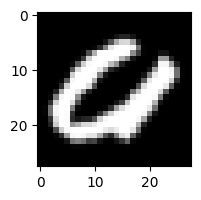

ASCII: 72
Character: H


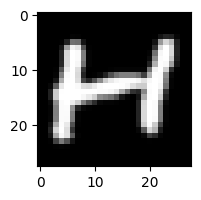

ASCII: 79
Character: O


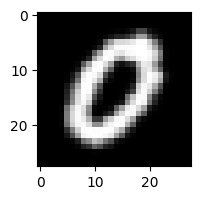

In [17]:
# Print the first thress images.
for i in range(3):
    printImg([i], x_train, y_train)

För att kunna använda vår data måste vi även justera varje bilds storlek, färgkanaler och invertera dessa färger (p.g.a. hur programmet är byggt där modellen ska anvädnas). Vi gör detta genom funktionen **img_transform** i kodblocket nedan.

In [18]:
# Code taken from canvas course page and slightly modified by student to also take in image size and call to_categorical().
# Note that anitalias has been set top True.
# Define an in-stream transform (gray2color, resize)
def img_transform(images, image_size):
    #images = tf.image.grayscale_to_rgb(tf.convert_to_tensor(images))
    images = tf.image.resize_with_pad(images, image_size[0], image_size[1], antialias=True)
    images = 1 - images
    return images

2024-01-11 11:42:29.687678: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 11:42:29.688107: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 11:42:29.688639: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

ASCII: 81
Character: Q


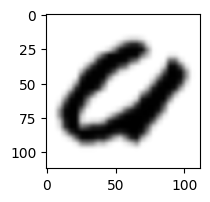

ASCII: 72
Character: H


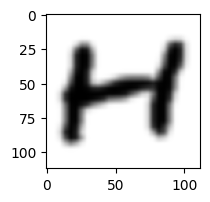

ASCII: 79
Character: O


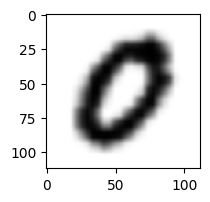

In [19]:
# Prin the first three images transformed.
for i in range(3):
    printImg([i], img_transform(x_train[:3], image_size), y_train)

Bilderna skrevs ut korrekt. Vi ser att det är samma bilder, men i lite högre upplösning och ANTIALIAS.

Och för att omptimera minnesanvändningen vid träning och test ska vi använda data generatorer/flöden. Detta gör vi genom **DataGenerator** klassen som skapats nedan. Den ser till att justera bildedatan allt eftersom för att inte fylla datorns minne för snabbt.

In [20]:
# Data generator/stream used for better memoery management.
# Note that the base for this class was fetched from a previous lab.
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size, img_size):
        self.x, self.y = x_set, to_categorical(y_set)
        self.batch_size = batch_size
        self.img_size = img_size
        # Data augmentation.
        self.datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=5,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.15,
            fill_mode='constant',
            cval=255)

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Transform image data.
        x = img_transform(batch_x, self.img_size)

        # Apply augmentation.
        x = self.datagen.flow(
            x,
            batch_size=self.batch_size,
            shuffle=False
            ).next()

        return np.array(x), np.array(batch_y)

## Utforska potentiella modeller med Keras Tuner

Att använda Keras Tuner för att hitta den optimala modellen är ett bra alternativ, men inte särskillt hållbart. Anledningen till detta är att Xception är en komplex modell som leder till att utforkning av modeller som använder överförd inlärning från denna tar extremt lång tid för ett low-end kort så som RTX 2070-Super som använder vid detta projekt. En rad körning gjordes med Keras Tuner med behövde stoppas p.g.a. de långa körningstiderna.

Trotts de långa körningstiderna kunde de resultat som hann hittas användas för att ta fram den slutgiltiga modellen. Mer om detta längre ner.

Det första steget för att göra detta var att utforska Xception modellen. Detta körs i kodblocket nedan fär vi ser att tre potentiella platser att kapa modellen är vid lager index $24$, $34$, och $54$. Alla dessa tre platser skickades till metoden som byggde modellerna att utforskas av Keras Tuner.

In [21]:
# Make an Xception model and summarize it for analysis.
#xception_model = keras.applications.xception.Xception(weights='imagenet', include_top=False, input_shape=image_size)
#xception_model.summary()

In [22]:
# Function that builds models to be explored using Keras tuner.
def buildExploringModel(hp, input_shape):

    model = keras.Sequential()


    # Conv2D layers s1.
    num_conv2d_layers_s1 = hp.Int('num_conv2d_layers_s1', 1, 2, 3)
    filter_conv2d_layers_s1 = hp.Int('filter_conv2d_layers_s1', min_value=16, max_value=64, step=16)
    for i in range(num_conv2d_layers_s1):
        model.add(Conv2D(
            filters=filter_conv2d_layers_s1,
            activation='relu',
            input_shape=image_size,
            kernel_size=hp.Choice(f'kernel_conv2d_s1_{i}', values=[3, 5]),
            strides=hp.Choice(f'strides_conv2d_s1_{i}', values=[1, 2]),
            padding='same'
        ))
    model.add(MaxPool2D())
    model.add(BatchNormalization(axis=-1))

    # Conv2D layers s2.
    num_conv2d_layers_s2 = hp.Int('num_conv2d_layers_s2', 1, 3)
    filter_conv2d_layers_s2 = hp.Int('filter_conv2d_layers_s2', min_value=32, max_value=256, step=32)
    for i in range(num_conv2d_layers_s2):
        model.add(Conv2D(
            filters=filter_conv2d_layers_s2,
            activation='relu',
            input_shape=image_size,
            kernel_size=3,
            strides=hp.Choice(f'strides_conv2d_s2_{i}', values=[1, 2]),
            padding='same'
        ))
    model.add(MaxPool2D())
    model.add(BatchNormalization(axis=-1))

    # Conv2D layers s3.
    num_conv2d_layers_s3 = hp.Int('num_conv2d_layers_s3', 1, 3)
    filter_conv2d_layers_s3 = hp.Int('filter_conv2d_layers_s3', min_value=64, max_value=512, step=64)
    for i in range(num_conv2d_layers_s3):
        model.add(Conv2D(
            filters=filter_conv2d_layers_s3,
            activation='relu',
            input_shape=image_size,
            kernel_size=3,
            strides=hp.Choice(f'strides_conv2d_s3_{i}', values=[1, 2]),
            padding='same'
        ))
    model.add(MaxPool2D())
    model.add(BatchNormalization(axis=-1))

    # Conv2D layers s4.
    num_conv2d_layers_s4 = hp.Int('num_conv2d_layers_s4', 1, 3)
    filter_conv2d_layers_s4 = hp.Int('filter_conv2d_layers_s4', min_value=64, max_value=512, step=64)
    for i in range(num_conv2d_layers_s4):
        model.add(Conv2D(
            filters=filter_conv2d_layers_s4,
            activation='relu',
            input_shape=image_size,
            kernel_size=3,
            strides=hp.Choice(f'strides_conv2d_s3_{i}', values=[1, 2]),
            padding='same'
        ))
    model.add(MaxPool2D())

    # Add our dense layers to the end.
    model.add(Flatten())
    model.add(BatchNormalization(axis=-1))

    # Dense layers s5.
    num_dense_layers_s5 = hp.Int('num_dense_layers_s5', 1, 4)
    for i in range(num_dense_layers_s5):
        model.add(Dense(
            units=hp.Int(f'dense_{i}_units_s5', min_value=64, max_value=2048, step=64),
            activation='relu'
        ))
    model.add(Dropout(rate=hp.Float(f'dropout_s5', min_value=0.0,max_value=0.8,default=0.6,step=0.05,)))

    # Dense layers s2.
    #num_dense_layers_s2 = hp.Int('num_dense_layers_s2', 1, 4)
    #for i in range(num_dense_layers_s2):
    #    x = Dense(
    #        units=hp.Int(f'dense_{i}_units_s2', min_value=64, max_value=4096, step=64),
    #        activation='relu'
    #    )(x)
    #x = Dropout(rate=hp.Float(f'dropout_s2', min_value=0.0,max_value=0.8,default=0.4,step=0.05,))(x)

    model.add(Dense(len(ascii_codes), activation='softmax')) # Output layer.

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

    return model

In [23]:
# Import additional libraries.
from keras import backend as backend

# Function to call upon keras tuner.
def runTuner(max_trials, executions_per_trial, num_epoch_auto):

    # Define tuner.
    class MyTuner(keras_tuner.tuners.BayesianOptimization):
        def run_trial(self, trial, *args, **kwargs):
            # Clear up memory.
            backend.clear_session()
            gc.collect()
            # Add addtional kwargs.
            #kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 512, step=32, default=128)
            kwargs['batch_size'] = 256
            kwargs['validation_data'] = DataGenerator(x_val, y_val, batch_size = kwargs['batch_size'], img_size = image_size)
            # Add additional args.
            args = args + (DataGenerator(x_train, y_train, batch_size = kwargs['batch_size'], img_size = image_size),)
            return super(MyTuner, self).run_trial(trial, *args, **kwargs)

    # Bayesian search which also searches for batch_size
    tuner = MyTuner(
        lambda hp: buildExploringModel(hp, image_size), ##### Laboration: Change this to 'build_model_MyModel' #####
        max_trials              = max_trials,
        objective               = 'accuracy',
        executions_per_trial    = executions_per_trial,
        directory               = 'output',
        overwrite               = True,
        num_initial_points      = 10,
        project_name            = 'EMNIST_BALANCED'
    )

    # Perform hyperparameter search.
    es = keras.callbacks.EarlyStopping('val_loss', patience=2, restore_best_weights = True) # Setup early stopping.
    tuner.search(epochs=num_epoch_auto, callbacks=[es])

    return tuner

In [24]:
# A function to retreieve the best model found via a tuner
# as print out nececarry information about it.
def getBestModelFromTuner(tuner, show_trainable):
    # Get best model.
    model = tuner.get_best_models(num_models=1)[0]
    # Print its hyperparameters.
    vals = tuner.get_best_hyperparameters(num_trials=5)[0].values
    for keys,values in vals.items():
        print('%20s = %3.4g' %(keys,values))
    # Print a summary.
    model.summary(show_trainable=show_trainable)
    # Return the best model.
    return model

In [25]:
# Function to evaluate the model.
def evaluateModel(model, img_size):
    test_gen = DataGenerator(X_test, Y_test, batch_size = 64, img_size = img_size)
    test_loss, test_acc = model.evaluate(test_gen)
    print('Test accuracy: %.3f' % test_acc)

In [26]:
#tuner = runTuner(14, 2, 6)
#model = getBestModelFromTuner(tuner, True)
#evaluateModel(model, image_size)

På grund av crasher försvann data från körnigarna av Keras Tuner. Men datan som hittades visad på ett gott resultat när Xception kapades vid lagerindex $24$ och de komplakta lagrena i slutet var allt ifrån $64$ till $1024$ neuroner i storlerk. Dessutom märktes stora skillnader i modellstoreleken beroende på dessa inställningar, så för att modellen skulle kunnas tränas färdigt på en rimlig tid valdes en modell av storlek mindre. Se function **buildFinalModel** nedan.

## Bygg slutgiltig modell

När potentiella värden för den slutgiltiga modellen hade hittats skrevs funktionen **buildFinalModel** som skapar den slutgiltiga modellen. En relativt simpel modell men som kan prestera bra nog för dess syfte.

In [27]:
# Function that builds the final model to be used.
def buildFinalModel(inp_shape):

    model = keras.Sequential()

    # Conv2D layers s1.
    model.add(Conv2D(
        input_shape=inp_shape,
        filters=48,
        activation='relu',
        kernel_size=3,
        strides=2,
        padding='same'
    ))
    model.add(MaxPool2D())
    model.add(BatchNormalization(axis=-1))

    # Conv2D layers s2.
    model.add(Conv2D(
        filters=96,
        activation='relu',
        kernel_size=3,
        strides=2,
        padding='same'
    ))
    model.add(Conv2D(
        filters=96,
        activation='relu',
        kernel_size=3,
        strides=1,
        padding='same'
    ))
    model.add(MaxPool2D())
    model.add(BatchNormalization(axis=-1))

    # Conv2D layers s3.
    model.add(Conv2D(
        filters=256,
        activation='relu',
        kernel_size=3,
        strides=1,
        padding='same'
    ))
    model.add(MaxPool2D())

    # Add our dense layers to the end.
    model.add(Flatten())
    model.add(BatchNormalization(axis=-1))

    # Dense layers s5.
    model.add(Dense(
        units=704,
        activation='relu'
    ))
    model.add(Dense(
        units=384,
        activation='relu'
    ))
    model.add(Dense(
        units=512,
        activation='relu'
    ))
    model.add(Dropout(rate=0.15))

    model.add(Dense(len(ascii_codes), activation='softmax')) # Output layer.

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

    return model

In [28]:
model = buildFinalModel(image_size)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 48)        480       
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 28, 48)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 28, 28, 48)        192       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 96)        41568     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 96)        83040     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 96)          0

## Träning av modell

För att enkelt träna den slutgiltiga modellen används ett flertal funktioner för att skriva ut träningshistoriken, justera vilka lager som är träningsbara, och en sammanfattat träningsfuntion som bara kortar ner koden avsevärt.

Efter att ha testat träna modellen ett flertal gånger hittades en passande metod att träna den på. Knepet var att först träna de kompakta lagren som kommer efter Xception modellens lager relativt aggresivt, för att sedan träna hela modellen långsammare (lägre inlärningstakt).

In [29]:
# Function used for ploting the training history.
# Note that this function is based on a function given to
# the student trough a previous lab.
def printHistory(history):

  # Collect the number of epochs run based on the amount of loss value under history.
	epochs = len(history.history['loss']) 
	epochrange = range(1, epochs + 1)
	
  # Select accuracy data.
	train_acc = history.history['accuracy']
	val_acc = history.history['val_accuracy']

  # Select loss data.
	train_loss = history.history['loss']
	val_loss = history.history['val_loss']

  # Plot accuracy.
	plt.plot(epochrange, train_acc, 'bo', label='Training acc')
	plt.plot(epochrange, val_acc, 'b', label='Validation acc')
	plt.title('Training and validation accuracy (modell 1)')
	plt.xlabel('Epochs')
	plt.ylabel('Accuracy')
	plt.legend()
	plt.show()

  # Plot loss.
	plt.plot(epochrange, train_loss, 'bo', label='Training loss')
	plt.plot(epochrange, val_loss, 'b', label='Validation loss')
	plt.title('Training and validation loss (modell 1)')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.legend()
	plt.show()

In [30]:
# Function to train the model.
# This is used so taht we easily can call upon training multiple times
# with different arguments to archieve better results and easier
# tune the given arguments.
def trainModel(model, batch_size, epochs, show_history, new_learning_rate, image_size):

    # Generate data streams from data sets.
    train_gen = DataGenerator(x_train, y_train, batch_size = batch_size, img_size = image_size)
    val_gen = DataGenerator(x_val, y_val, batch_size = batch_size, img_size = image_size)
    #test_gen = DataGenerator(X_test, Y_test, batch_size = batch_size, img_size = image_size)

    # Set a new learning rate.
    model.optimizer.learning_rate.assign(new_learning_rate)

    history = model.fit(
        train_gen,
        epochs = epochs,
        shuffle = True,
        verbose = 2,
        validation_data = val_gen,
        callbacks = EarlyStopping('val_loss', patience=3, restore_best_weights=True)
    )

    # Print history.
    if show_history: printHistory(history)

In [31]:
# Function to set trainability of layers in a model
# up to (and including) a given layer.
# This can be used for dividing up the training of a model.
# Example of calling:
# setTrainability(finalModel, False, 10)
def setTrainability(model, target_state, up_until):
    for i in range(len(model.layers)):
        model.layers[i].trainable = target_state
        if i == up_until:
            break

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 56, 56, 48)        480       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 28, 28, 48)        0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 28, 28, 48)        192       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 96)        41568     
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 96)        83040     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 96)         

2024-01-10 21:31:03.897740: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-10 21:31:04.007343: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-10 21:31:07.809795: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff668003750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-10 21:31:07.809842: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2024-01-10 21:31:07.824728: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704918667.947138   16546 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


270/270 - 95s - loss: 3.6274 - accuracy: 0.0268 - val_loss: 3.5936 - val_accuracy: 0.0266 - 95s/epoch - 352ms/step
Epoch 2/32
270/270 - 88s - loss: 3.5992 - accuracy: 0.0271 - val_loss: 3.5905 - val_accuracy: 0.0281 - 88s/epoch - 325ms/step
Epoch 3/32
270/270 - 87s - loss: 3.5941 - accuracy: 0.0280 - val_loss: 3.5897 - val_accuracy: 0.0301 - 87s/epoch - 323ms/step
Epoch 4/32
270/270 - 88s - loss: 3.5913 - accuracy: 0.0284 - val_loss: 3.5879 - val_accuracy: 0.0273 - 88s/epoch - 324ms/step
Epoch 5/32
270/270 - 87s - loss: 3.5889 - accuracy: 0.0284 - val_loss: 3.5885 - val_accuracy: 0.0269 - 87s/epoch - 321ms/step
Epoch 6/32
270/270 - 89s - loss: 3.5884 - accuracy: 0.0273 - val_loss: 3.5888 - val_accuracy: 0.0259 - 89s/epoch - 331ms/step
Epoch 7/32
270/270 - 89s - loss: 3.5876 - accuracy: 0.0277 - val_loss: 3.5863 - val_accuracy: 0.0258 - 89s/epoch - 330ms/step
Epoch 8/32
270/270 - 87s - loss: 3.5861 - accuracy: 0.0279 - val_loss: 3.5847 - val_accuracy: 0.0278 - 87s/epoch - 324ms/step
Epo

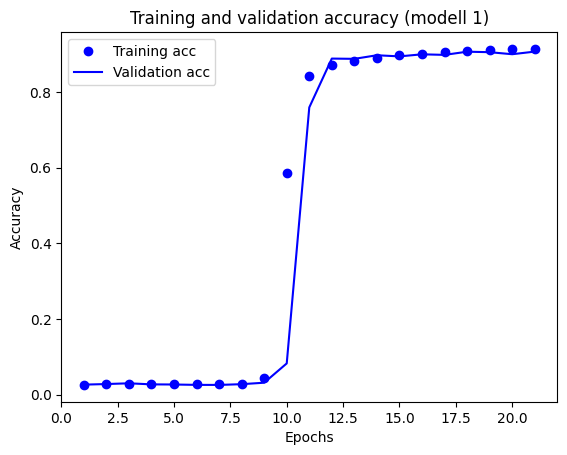

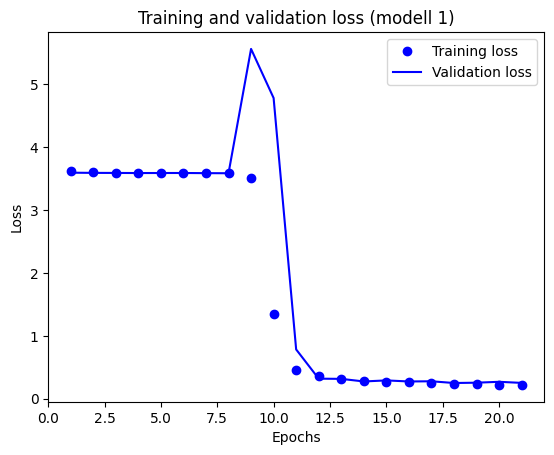

Epoch 1/32
540/540 - 97s - loss: 0.2549 - accuracy: 0.9013 - val_loss: 0.2961 - val_accuracy: 0.8887 - 97s/epoch - 179ms/step
Epoch 2/32
540/540 - 93s - loss: 0.2411 - accuracy: 0.9063 - val_loss: 0.2517 - val_accuracy: 0.9035 - 93s/epoch - 172ms/step
Epoch 3/32
540/540 - 94s - loss: 0.2296 - accuracy: 0.9095 - val_loss: 0.2571 - val_accuracy: 0.9031 - 94s/epoch - 173ms/step
Epoch 4/32
540/540 - 94s - loss: 0.2213 - accuracy: 0.9135 - val_loss: 0.2552 - val_accuracy: 0.9042 - 94s/epoch - 175ms/step
Epoch 5/32
540/540 - 94s - loss: 0.2133 - accuracy: 0.9149 - val_loss: 0.2434 - val_accuracy: 0.9092 - 94s/epoch - 174ms/step
Epoch 6/32
540/540 - 95s - loss: 0.2059 - accuracy: 0.9177 - val_loss: 0.2549 - val_accuracy: 0.9042 - 95s/epoch - 177ms/step
Epoch 7/32
540/540 - 95s - loss: 0.2019 - accuracy: 0.9188 - val_loss: 0.2365 - val_accuracy: 0.9107 - 95s/epoch - 176ms/step
Epoch 8/32
540/540 - 95s - loss: 0.1972 - accuracy: 0.9205 - val_loss: 0.2363 - val_accuracy: 0.9109 - 95s/epoch - 175

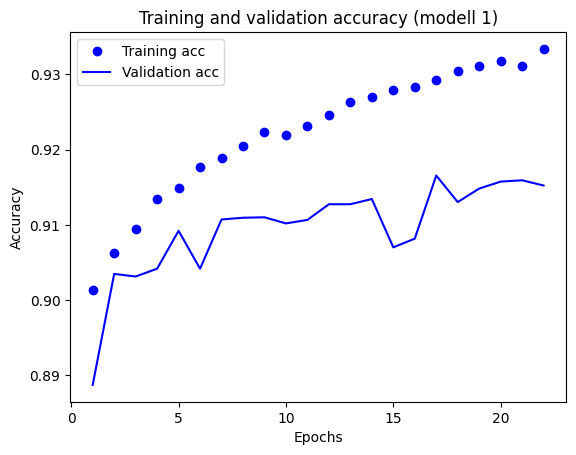

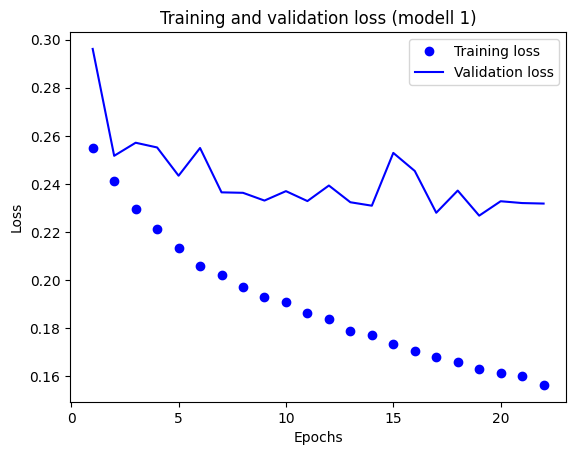

Epoch 1/64
1080/1080 - 111s - loss: 0.1641 - accuracy: 0.9302 - val_loss: 0.2206 - val_accuracy: 0.9177 - 111s/epoch - 103ms/step
Epoch 2/64
1080/1080 - 108s - loss: 0.1585 - accuracy: 0.9331 - val_loss: 0.2193 - val_accuracy: 0.9203 - 108s/epoch - 100ms/step
Epoch 3/64
1080/1080 - 107s - loss: 0.1552 - accuracy: 0.9337 - val_loss: 0.2205 - val_accuracy: 0.9195 - 107s/epoch - 99ms/step
Epoch 4/64
1080/1080 - 108s - loss: 0.1525 - accuracy: 0.9361 - val_loss: 0.2215 - val_accuracy: 0.9166 - 108s/epoch - 100ms/step
Epoch 5/64
1080/1080 - 109s - loss: 0.1523 - accuracy: 0.9351 - val_loss: 0.2176 - val_accuracy: 0.9209 - 109s/epoch - 100ms/step
Epoch 6/64
1080/1080 - 111s - loss: 0.1472 - accuracy: 0.9360 - val_loss: 0.2184 - val_accuracy: 0.9214 - 111s/epoch - 103ms/step
Epoch 7/64
1080/1080 - 105s - loss: 0.1481 - accuracy: 0.9361 - val_loss: 0.2235 - val_accuracy: 0.9183 - 105s/epoch - 98ms/step
Epoch 8/64
1080/1080 - 104s - loss: 0.1460 - accuracy: 0.9378 - val_loss: 0.2242 - val_accur

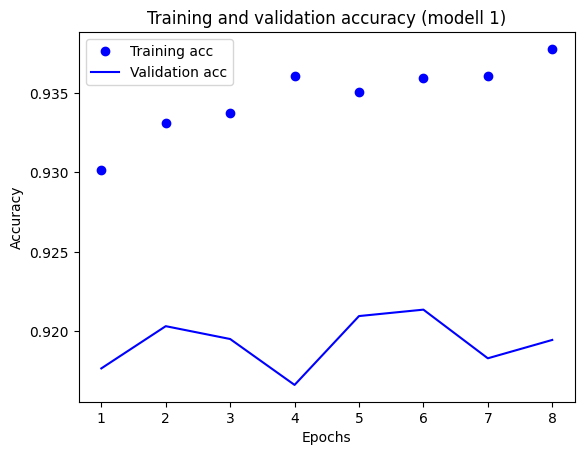

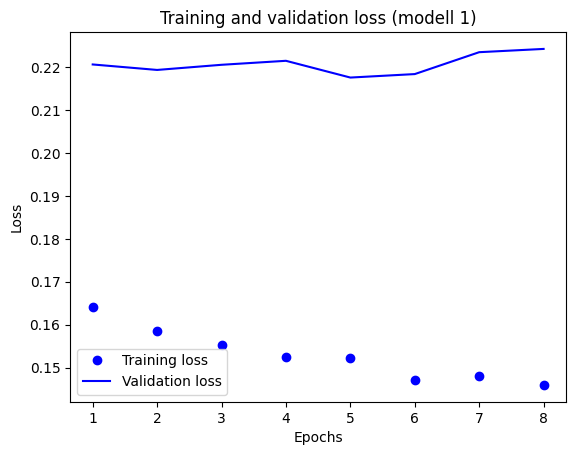

Epoch 1/128
2160/2160 - 125s - loss: 0.1508 - accuracy: 0.9362 - val_loss: 0.2127 - val_accuracy: 0.9229 - 125s/epoch - 58ms/step
Epoch 2/128
2160/2160 - 122s - loss: 0.1477 - accuracy: 0.9370 - val_loss: 0.2135 - val_accuracy: 0.9249 - 122s/epoch - 57ms/step
Epoch 3/128
2160/2160 - 123s - loss: 0.1436 - accuracy: 0.9386 - val_loss: 0.2133 - val_accuracy: 0.9240 - 123s/epoch - 57ms/step
Epoch 4/128
2160/2160 - 123s - loss: 0.1426 - accuracy: 0.9386 - val_loss: 0.2147 - val_accuracy: 0.9217 - 123s/epoch - 57ms/step


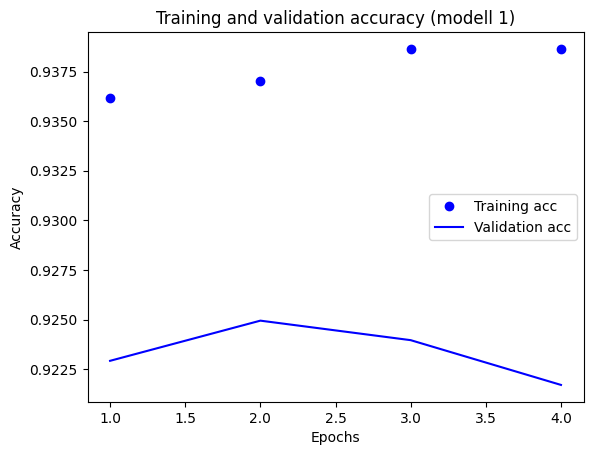

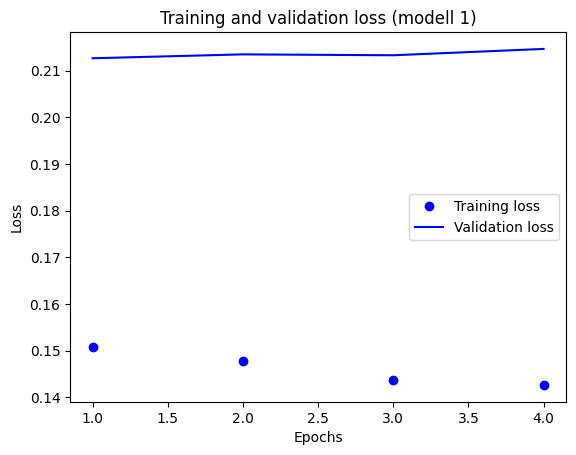

225/225 [==============================] - 18s 79ms/step - loss: 0.2162 - accuracy: 0.9225
Test accuracy: 0.923


In [32]:
# Build the final model and print out a summary.
model = buildFinalModel(image_size)
model.summary()

# Train the first layers added by student at a high phase.
#setTrainability(model, False, 34)
trainModel(model, 256, 32, True, 0.0001, image_size)
trainModel(model, 128, 32, True, 0.0001, image_size)
trainModel(model, 64, 64, True, 0.00005, image_size)
trainModel(model, 32, 128, True, 0.00001, image_size)

# Train all layers at a lower phase (fuse the Xception layers together with the last Dense layers).
#setTrainability(model, True, 34)
#trainModel(model, 16, 128, True, 0.0001, image_size)

# Evaluate model.
evaluateModel(model, image_size)

Träningsförloppet ovan visar en snabb och plötslig förbättring under den första körningen. Efter det kraftiga hoppet från låga procent i träffsäkerhet till höga saktade träningen ner. Men genom att köra träningen ytterligare gånger med lägre hastighet kunde denna procent pressas ytterligare ända upp till $92.3%$. Ett acceptabelt resultat i detta fall.

In [33]:
# Export the model so that it can be used in the program.
model.save("character_classification_model_101")

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff71b889d80>, 140701789090432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff71b889d80>, 140701789090432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff71b8e36d0>, 140701789092672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff71b8e36d0>, 140701789092672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff71b88bf40>, 140703845736224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff71b88bf40>, 140703845736224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff71b88bc10>, 140703845736144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff71b88bc10>, 140703845736144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef13c8b0>, 140703845735184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef13c8b0>, 140703845735184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef13d930>, 140703845735104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef13d930>, 140703845735104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 96, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef184a60>, 140703845738064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 96, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef184a60>, 140703845738064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef185ae0>, 140703845738464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef185ae0>, 140703845738464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2304, 704), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef1d0d00>, 140703845785376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2304, 704), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef1d0d00>, 140703845785376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(704,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef1d1d80>, 140703845786016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(704,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef1d1d80>, 140703845786016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(704, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef1d2da0>, 140703845729744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(704, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef1d2da0>, 140703845729744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef1d3e50>, 140703845788336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef1d3e50>, 140703845788336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff7b0040eb0>, 140703845779696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff7b0040eb0>, 140703845779696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff7b0041f30>, 140703845778656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff7b0041f30>, 140703845778656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 36), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff7b0042f50>, 140703845792176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 36), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff7b0042f50>, 140703845792176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(36,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff7b0043fd0>, 140703845791296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(36,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff7b0043fd0>, 140703845791296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f3ba470>, 140701789090432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f3ba470>, 140701789090432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f3bb670>, 140701789092672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f3bb670>, 140701789092672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f3e4d30>, 140703845736224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f3e4d30>, 140703845736224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f3e5d50>, 140703845736144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f3e5d50>, 140703845736144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f3e6d10>, 140703845735184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f3e6d10>, 140703845735184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f3e7d30>, 140703845735104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f3e7d30>, 140703845735104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 96, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f22d3f0>, 140703845738064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 96, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f22d3f0>, 140703845738064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f22e410>, 140703845738464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f22e410>, 140703845738464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2304, 704), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f22fac0>, 140703845785376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2304, 704), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f22fac0>, 140703845785376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(704,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f274b20>, 140703845786016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(704,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f274b20>, 140703845786016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(704, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f275ae0>, 140703845729744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(704, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f275ae0>, 140703845729744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f276b00>, 140703845788336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f276b00>, 140703845788336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f277ac0>, 140703845779696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f277ac0>, 140703845779696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f2b0b50>, 140703845778656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f2b0b50>, 140703845778656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 36), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f2b1b10>, 140703845792176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 36), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f2b1b10>, 140703845792176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(36,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f2b2b30>, 140703845791296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(36,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f2b2b30>, 140703845791296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff71b889d80>, 140701789090432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff71b889d80>, 140701789090432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff71b8e36d0>, 140701789092672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff71b8e36d0>, 140701789092672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff71b88bf40>, 140703845736224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff71b88bf40>, 140703845736224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff71b88bc10>, 140703845736144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff71b88bc10>, 140703845736144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef13c8b0>, 140703845735184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef13c8b0>, 140703845735184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef13d930>, 140703845735104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef13d930>, 140703845735104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 96, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef184a60>, 140703845738064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 96, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef184a60>, 140703845738064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef185ae0>, 140703845738464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef185ae0>, 140703845738464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2304, 704), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef1d0d00>, 140703845785376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2304, 704), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef1d0d00>, 140703845785376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(704,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef1d1d80>, 140703845786016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(704,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef1d1d80>, 140703845786016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(704, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef1d2da0>, 140703845729744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(704, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef1d2da0>, 140703845729744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef1d3e50>, 140703845788336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff6ef1d3e50>, 140703845788336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff7b0040eb0>, 140703845779696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff7b0040eb0>, 140703845779696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff7b0041f30>, 140703845778656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff7b0041f30>, 140703845778656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 36), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff7b0042f50>, 140703845792176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 36), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff7b0042f50>, 140703845792176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(36,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff7b0043fd0>, 140703845791296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(36,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff7b0043fd0>, 140703845791296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f3ba470>, 140701789090432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f3ba470>, 140701789090432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f3bb670>, 140701789092672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f3bb670>, 140701789092672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f3e4d30>, 140703845736224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f3e4d30>, 140703845736224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f3e5d50>, 140703845736144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f3e5d50>, 140703845736144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f3e6d10>, 140703845735184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f3e6d10>, 140703845735184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f3e7d30>, 140703845735104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f3e7d30>, 140703845735104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 96, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f22d3f0>, 140703845738064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 96, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f22d3f0>, 140703845738064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f22e410>, 140703845738464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f22e410>, 140703845738464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2304, 704), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f22fac0>, 140703845785376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2304, 704), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f22fac0>, 140703845785376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(704,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f274b20>, 140703845786016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(704,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f274b20>, 140703845786016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(704, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f275ae0>, 140703845729744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(704, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f275ae0>, 140703845729744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f276b00>, 140703845788336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f276b00>, 140703845788336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f277ac0>, 140703845779696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f277ac0>, 140703845779696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f2b0b50>, 140703845778656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f2b0b50>, 140703845778656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 36), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f2b1b10>, 140703845792176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 36), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f2b1b10>, 140703845792176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(36,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f2b2b30>, 140703845791296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(36,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7ff82f2b2b30>, 140703845791296), {}).


INFO:tensorflow:Assets written to: character_classification_model_101/assets


INFO:tensorflow:Assets written to: character_classification_model_101/assets


In [99]:
"""
This codeblock contains a function that explores the failed classifications
by identifiyng them qmongst X amount of classifications and prints out a 
confusion matrix as well as the images for a better understanding for what
went wrong.

Notes:
1. The confusion matrix prints out the errors not by using sample_weight
but this can be removed if we only add to the array predictions_softmax
when there's been an error in the prediction.
"""

# Include what's missing.
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Load mode.
loaded_model = keras.models.load_model('character_classification_model_101')

def exploreErrors(amount, max_images_to_print = None):

    # Transform data and predict classes.
    img = img_transform(X_test[:amount], image_size)
    predictions = loaded_model.predict(img)

    # Prepare a softmax array (uesd for confusion matrix).
    predictions_softmax = []

    images_printed = 0
    for i in range(len(predictions)):

        # Transform prediction data.
        pred_class = np.argmax(predictions[i])
        pred_acci = int(ascii_codes[pred_class])
        pred_char = chr(pred_acci)
        certainty = max(predictions[i])

        # Add prediction to arr.
        predictions_softmax.append(pred_char)

        # Print images.
        if pred_class != Y_test[i] and max_images_to_print != None and images_printed < max_images_to_print:

            print(f"Predicted: {pred_char}")
            print(f"Certainty: {certainty}")

            printImg([i], img, Y_test)

            images_printed += 1

    """
    This secion prepares the data to be used in a confusion matrix.
    """
    predictions_softmax = np.array(predictions_softmax)

    y_test = []
    for i in range(amount):
        y_test.append(chr(ascii_codes[Y_test[i]]))
    y_test = np.array(y_test)


    labels = []
    for i in range(len(ascii_codes)):
        labels.append(chr(ascii_codes[i]))

    # We use sample_weight to flip the confusion matrix (to display the errors).
    sample_weight = (predictions_softmax.astype(str) != y_test[:amount].astype(str))

    # Plot the matrix.
    cm = confusion_matrix(y_test[:amount].astype(str), predictions_softmax.astype(str), labels = labels, normalize="true", sample_weight=sample_weight)
    cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(15,15))
    cmp.plot(ax=ax, values_format=".1f")

Genom att kalla på funktionen **exploreErrors()** nedan får vi $100$ stycken bilder utskrivan på symboler som har klassifiserats inkorrekt ihop med de korrekta klasserna. Dessutom får vi en "confusion matrix" som visar på vart de vanligaste "förvirringar" uppstår för modellen. Och som man kan vänta sig handlar det främst om siffror som är relativt lika bokstäver samt utstickande och mycket otydliga handstilar.

450/450 [==============================] - 2s 4ms/step
Predicted: Z
Certainty: 0.55078125
ASCII: 50
Character: 2


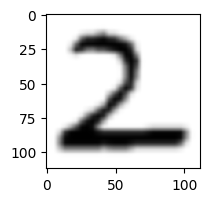

Predicted: 5
Certainty: 0.92041015625
ASCII: 83
Character: S


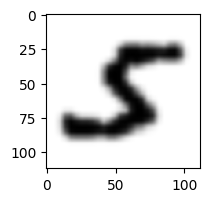

Predicted: I
Certainty: 0.4482421875
ASCII: 49
Character: 1


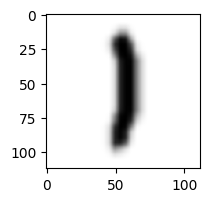

Predicted: L
Certainty: 0.57080078125
ASCII: 74
Character: J


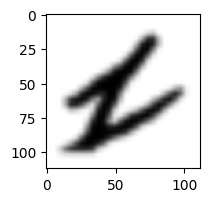

Predicted: H
Certainty: 0.919921875
ASCII: 78
Character: N


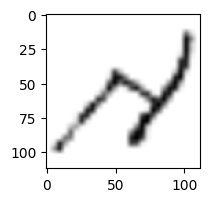

Predicted: Y
Certainty: 0.8837890625
ASCII: 57
Character: 9


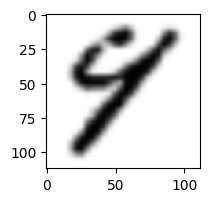

Predicted: G
Certainty: 0.533203125
ASCII: 48
Character: 0


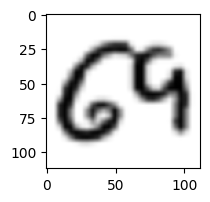

Predicted: 1
Certainty: 0.49072265625
ASCII: 76
Character: L


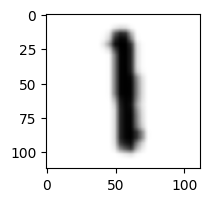

Predicted: 0
Certainty: 0.73095703125
ASCII: 79
Character: O


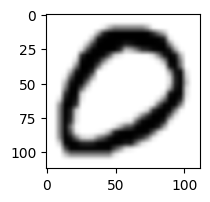

Predicted: D
Certainty: 0.607421875
ASCII: 80
Character: P


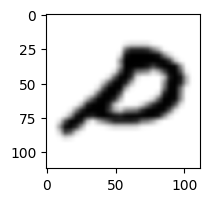

Predicted: 1
Certainty: 0.35693359375
ASCII: 76
Character: L


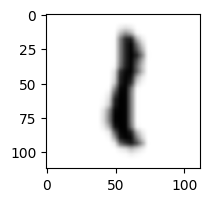

Predicted: Z
Certainty: 0.662109375
ASCII: 50
Character: 2


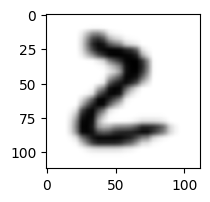

Predicted: L
Certainty: 0.5439453125
ASCII: 49
Character: 1


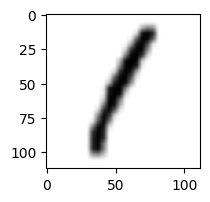

Predicted: 0
Certainty: 0.7626953125
ASCII: 79
Character: O


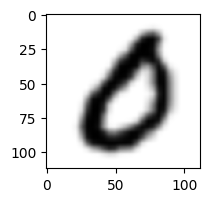

Predicted: 0
Certainty: 0.7490234375
ASCII: 79
Character: O


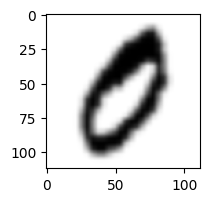

Predicted: I
Certainty: 0.85302734375
ASCII: 49
Character: 1


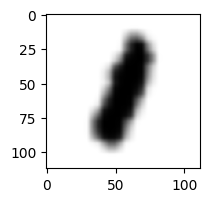

Predicted: S
Certainty: 0.95947265625
ASCII: 53
Character: 5


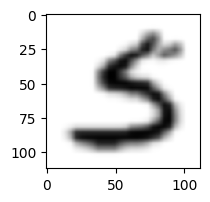

Predicted: N
Certainty: 0.99951171875
ASCII: 74
Character: J


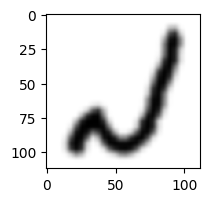

Predicted: 4
Certainty: 0.317138671875
ASCII: 76
Character: L


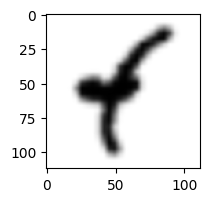

Predicted: L
Certainty: 0.67138671875
ASCII: 49
Character: 1


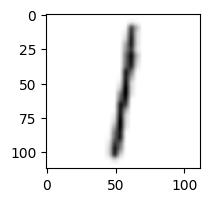

Predicted: I
Certainty: 0.77490234375
ASCII: 76
Character: L


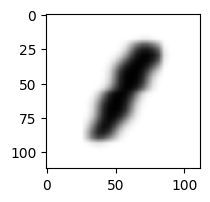

Predicted: I
Certainty: 0.53125
ASCII: 76
Character: L


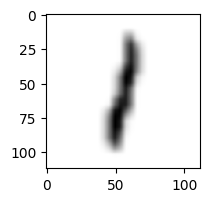

Predicted: I
Certainty: 0.5673828125
ASCII: 49
Character: 1


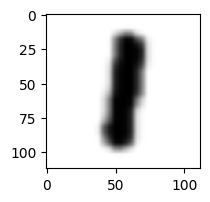

Predicted: Y
Certainty: 0.73974609375
ASCII: 84
Character: T


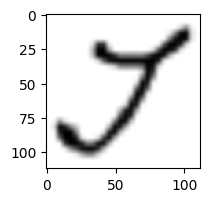

Predicted: L
Certainty: 0.57080078125
ASCII: 73
Character: I


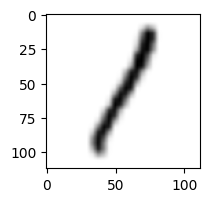

Predicted: J
Certainty: 0.80859375
ASCII: 50
Character: 2


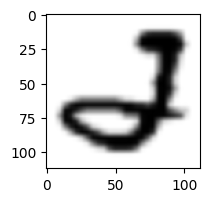

Predicted: L
Certainty: 0.56689453125
ASCII: 49
Character: 1


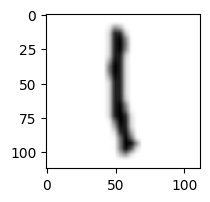

Predicted: L
Certainty: 0.44873046875
ASCII: 49
Character: 1


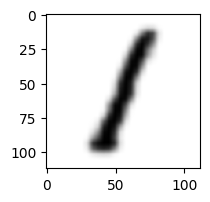

Predicted: 1
Certainty: 0.4267578125
ASCII: 73
Character: I


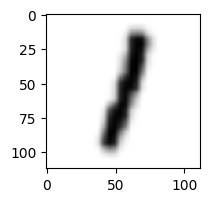

Predicted: V
Certainty: 0.9658203125
ASCII: 87
Character: W


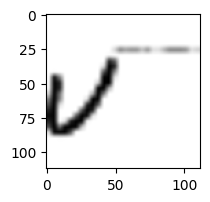

Predicted: 0
Certainty: 0.6904296875
ASCII: 79
Character: O


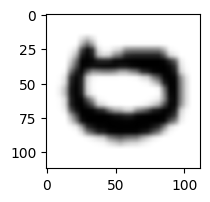

Predicted: 4
Certainty: 0.99755859375
ASCII: 88
Character: X


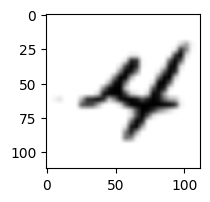

Predicted: L
Certainty: 0.498291015625
ASCII: 73
Character: I


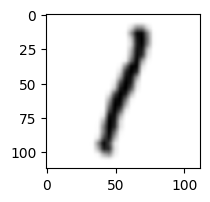

Predicted: 1
Certainty: 0.444091796875
ASCII: 73
Character: I


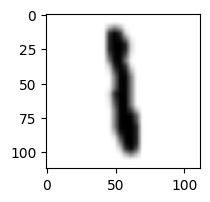

Predicted: 8
Certainty: 0.54150390625
ASCII: 66
Character: B


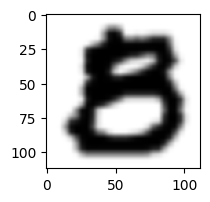

Predicted: Y
Certainty: 0.61083984375
ASCII: 52
Character: 4


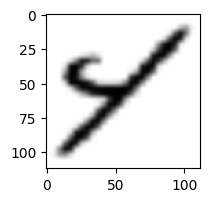

Predicted: O
Certainty: 0.8828125
ASCII: 52
Character: 4


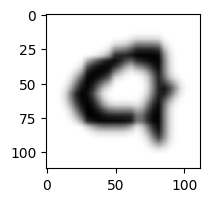

Predicted: 0
Certainty: 0.85302734375
ASCII: 79
Character: O


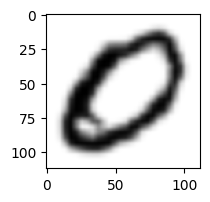

Predicted: I
Certainty: 0.36181640625
ASCII: 49
Character: 1


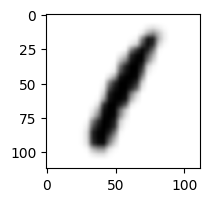

Predicted: L
Certainty: 0.5537109375
ASCII: 49
Character: 1


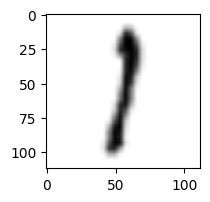

Predicted: L
Certainty: 0.374755859375
ASCII: 49
Character: 1


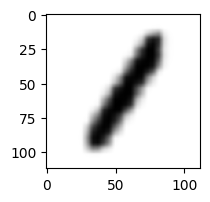

Predicted: 5
Certainty: 0.99560546875
ASCII: 74
Character: J


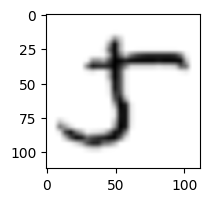

Predicted: N
Certainty: 0.603515625
ASCII: 77
Character: M


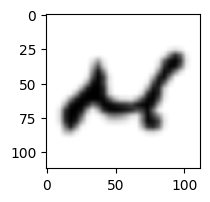

Predicted: 1
Certainty: 0.49169921875
ASCII: 76
Character: L


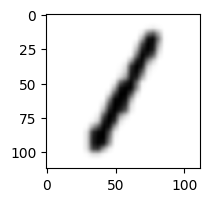

Predicted: L
Certainty: 0.5751953125
ASCII: 67
Character: C


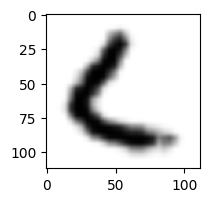

Predicted: 2
Certainty: 0.87646484375
ASCII: 90
Character: Z


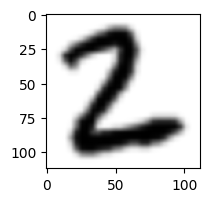

Predicted: Y
Certainty: 1.0
ASCII: 86
Character: V


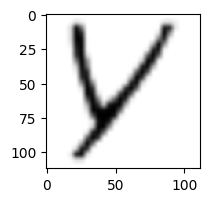

Predicted: 0
Certainty: 0.5673828125
ASCII: 79
Character: O


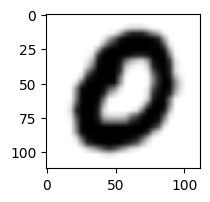

Predicted: L
Certainty: 0.5107421875
ASCII: 49
Character: 1


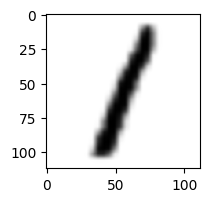

Predicted: 1
Certainty: 0.434814453125
ASCII: 73
Character: I


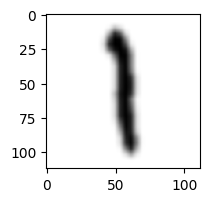

Predicted: 0
Certainty: 0.59619140625
ASCII: 79
Character: O


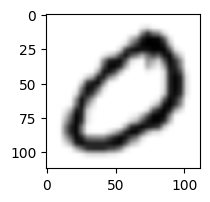

Predicted: 1
Certainty: 0.53125
ASCII: 73
Character: I


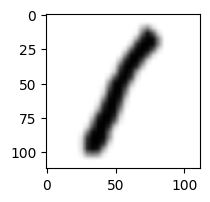

Predicted: 4
Certainty: 0.9736328125
ASCII: 89
Character: Y


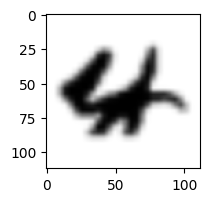

Predicted: I
Certainty: 0.7421875
ASCII: 76
Character: L


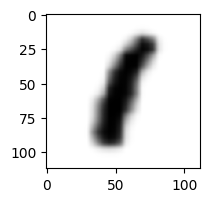

Predicted: O
Certainty: 0.5830078125
ASCII: 48
Character: 0


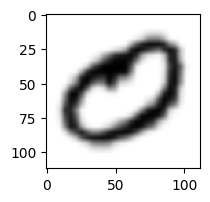

Predicted: 0
Certainty: 0.865234375
ASCII: 79
Character: O


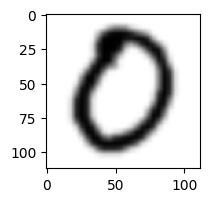

Predicted: 1
Certainty: 0.421630859375
ASCII: 76
Character: L


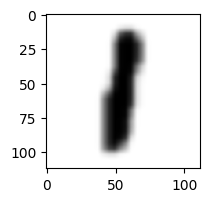

Predicted: K
Certainty: 0.496337890625
ASCII: 80
Character: P


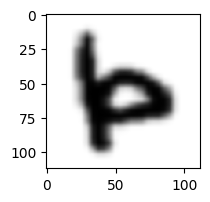

Predicted: 0
Certainty: 0.61083984375
ASCII: 79
Character: O


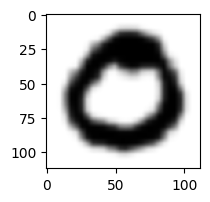

Predicted: I
Certainty: 0.51318359375
ASCII: 49
Character: 1


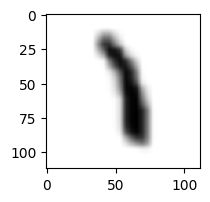

Predicted: 1
Certainty: 0.546875
ASCII: 76
Character: L


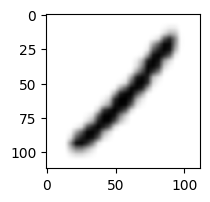

Predicted: L
Certainty: 0.74560546875
ASCII: 49
Character: 1


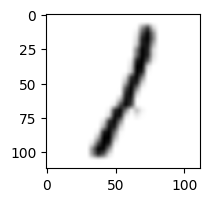

Predicted: 5
Certainty: 0.615234375
ASCII: 83
Character: S


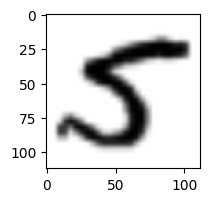

Predicted: O
Certainty: 0.7783203125
ASCII: 48
Character: 0


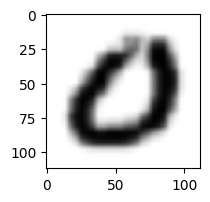

Predicted: L
Certainty: 0.59521484375
ASCII: 49
Character: 1


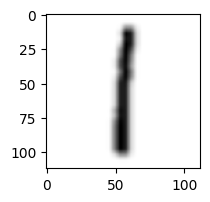

Predicted: I
Certainty: 0.82177734375
ASCII: 49
Character: 1


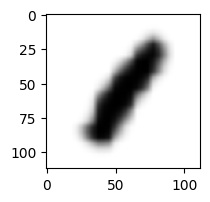

Predicted: U
Certainty: 0.83984375
ASCII: 89
Character: Y


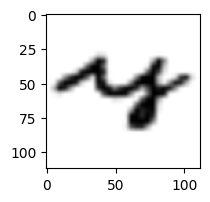

Predicted: L
Certainty: 0.71484375
ASCII: 73
Character: I


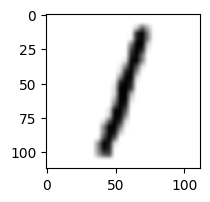

Predicted: B
Certainty: 0.63525390625
ASCII: 56
Character: 8


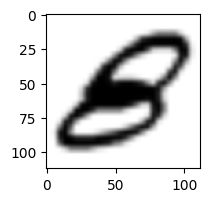

Predicted: L
Certainty: 0.486083984375
ASCII: 49
Character: 1


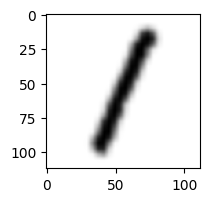

Predicted: O
Certainty: 0.58837890625
ASCII: 48
Character: 0


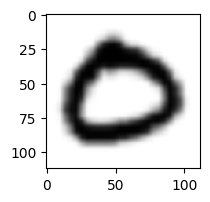

Predicted: 2
Certainty: 0.560546875
ASCII: 90
Character: Z


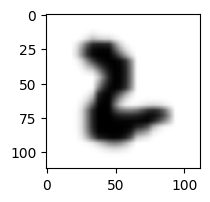

Predicted: 0
Certainty: 0.94384765625
ASCII: 79
Character: O


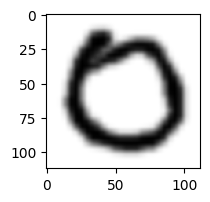

Predicted: O
Certainty: 0.57373046875
ASCII: 48
Character: 0


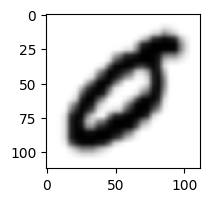

Predicted: I
Certainty: 0.466552734375
ASCII: 49
Character: 1


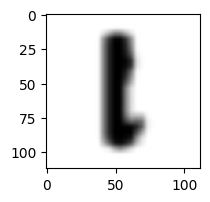

Predicted: Y
Certainty: 0.75048828125
ASCII: 88
Character: X


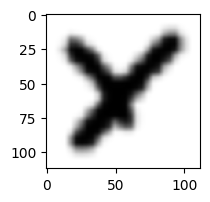

Predicted: L
Certainty: 0.433837890625
ASCII: 73
Character: I


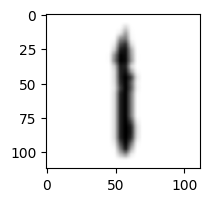

Predicted: L
Certainty: 0.52490234375
ASCII: 73
Character: I


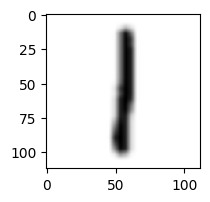

Predicted: 0
Certainty: 0.6240234375
ASCII: 79
Character: O


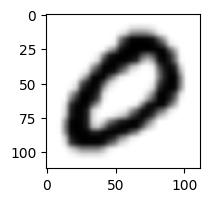

Predicted: L
Certainty: 0.75341796875
ASCII: 73
Character: I


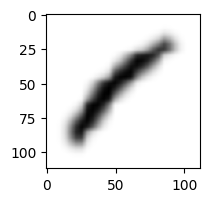

Predicted: O
Certainty: 0.7939453125
ASCII: 48
Character: 0


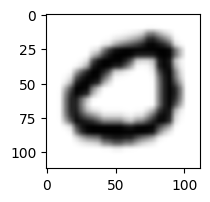

Predicted: L
Certainty: 0.4775390625
ASCII: 73
Character: I


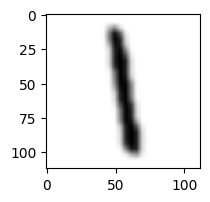

Predicted: 1
Certainty: 0.60205078125
ASCII: 73
Character: I


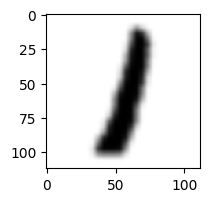

Predicted: Z
Certainty: 0.94189453125
ASCII: 50
Character: 2


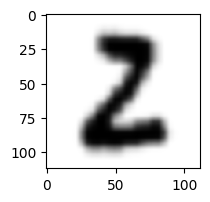

Predicted: L
Certainty: 0.626953125
ASCII: 73
Character: I


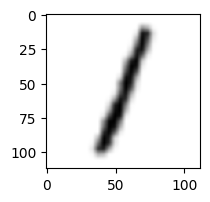

Predicted: 1
Certainty: 0.373779296875
ASCII: 76
Character: L


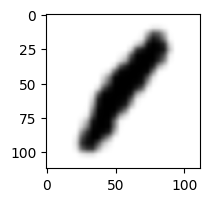

Predicted: 1
Certainty: 0.39453125
ASCII: 76
Character: L


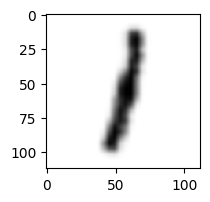

Predicted: O
Certainty: 0.52490234375
ASCII: 48
Character: 0


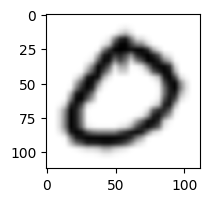

Predicted: L
Certainty: 0.49609375
ASCII: 49
Character: 1


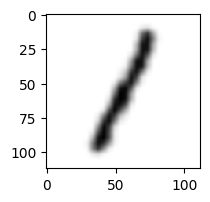

Predicted: L
Certainty: 0.435546875
ASCII: 49
Character: 1


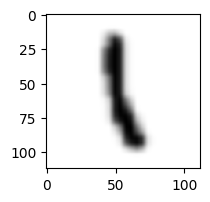

Predicted: 0
Certainty: 0.83251953125
ASCII: 79
Character: O


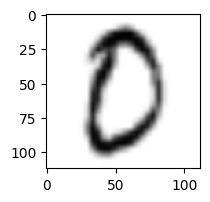

Predicted: L
Certainty: 0.7470703125
ASCII: 49
Character: 1


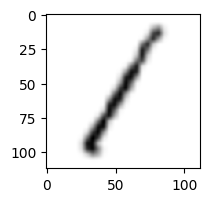

Predicted: M
Certainty: 0.9453125
ASCII: 89
Character: Y


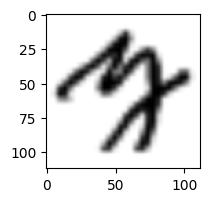

Predicted: U
Certainty: 0.787109375
ASCII: 89
Character: Y


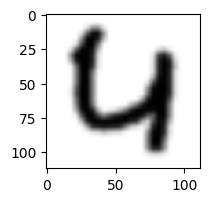

Predicted: 0
Certainty: 0.60205078125
ASCII: 79
Character: O


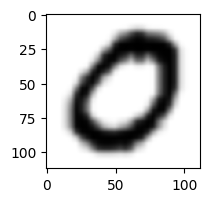

Predicted: L
Certainty: 0.413330078125
ASCII: 49
Character: 1


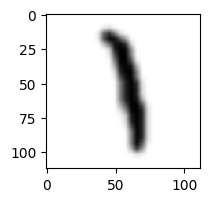

Predicted: 0
Certainty: 0.7822265625
ASCII: 79
Character: O


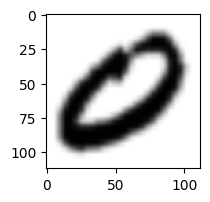

Predicted: 0
Certainty: 0.8046875
ASCII: 79
Character: O


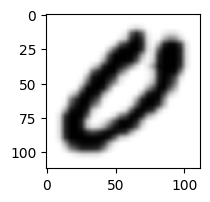

Predicted: D
Certainty: 0.54443359375
ASCII: 48
Character: 0


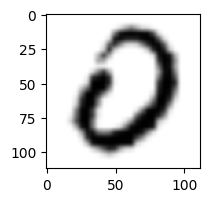

Predicted: O
Certainty: 0.75634765625
ASCII: 48
Character: 0


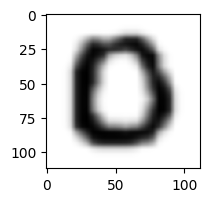

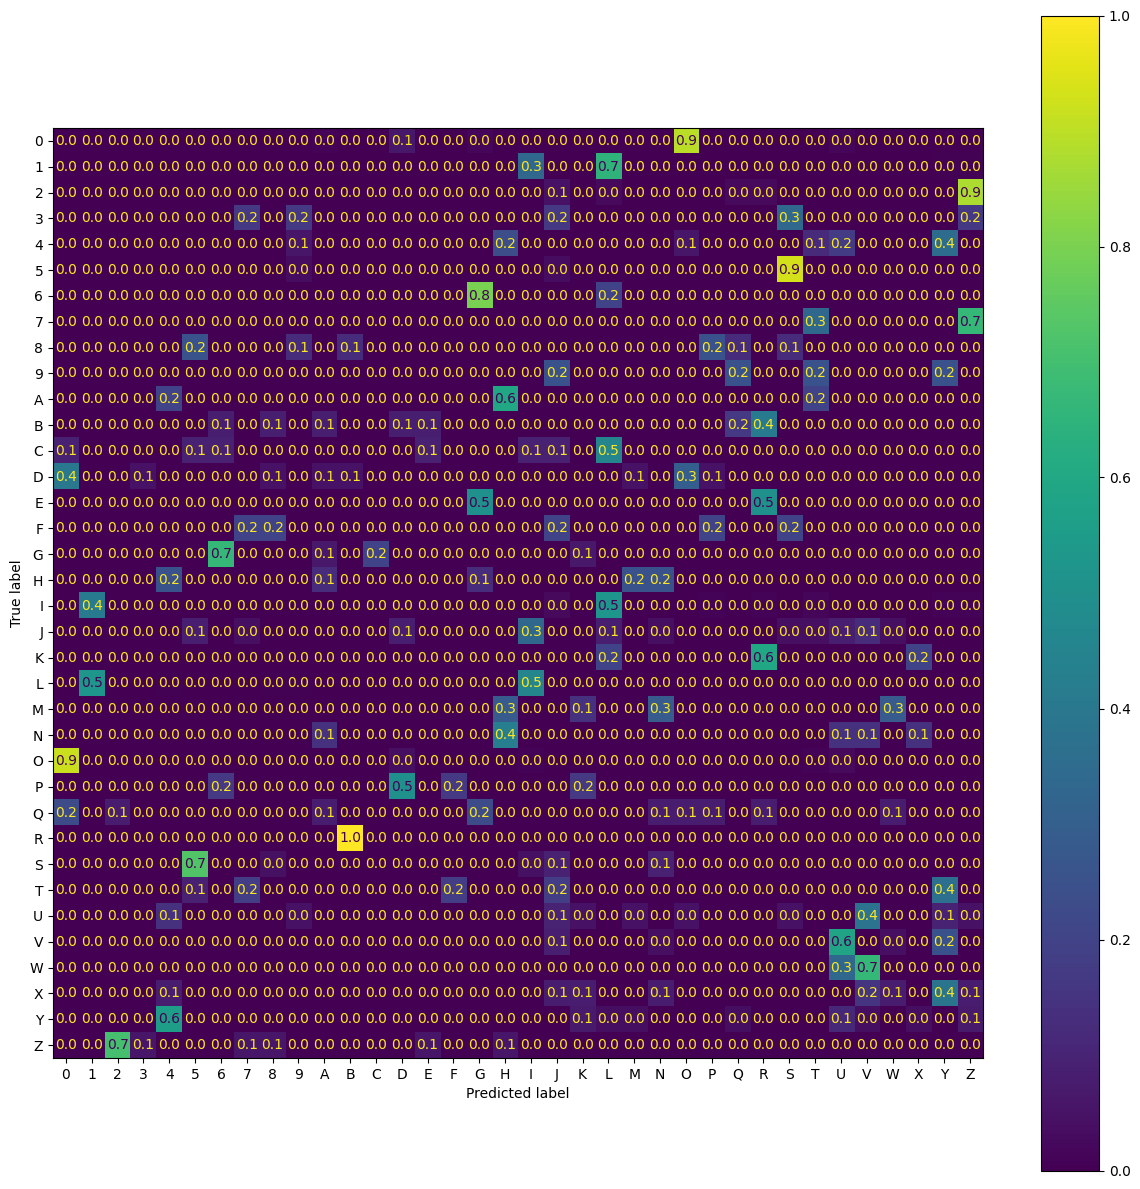

In [103]:
exploreErrors(14400, 100)